In [1]:
import os, sys
sys.path.append(r'/Users/khcho/Desktop/IRIS-moss-main/iris2plus/iris_lmsalpy')

import joblib
import gzip, pickle
import matplotlib.pyplot as plt
import glob, os, pdb
import numpy as np
import matplotlib.pyplot as plt
# from iris_lmsalpy.saveall import load --> Do not use. we need to use keyword in joblib.load function. If not, all data will stay in memory
from scipy.io import readsav
from scipy import stats
import xarray as xr
xr.set_options(keep_attrs=True)
import astropy.time as time 
import joblib

# Load the joblib file
file_path = '/Users/khcho/Desktop/IRIS-moss-main/iris2plus/chro_photo/'
os.chdir(file_path)

iris2p_files = sorted(glob.glob(file_path+'inv_mod_IRIS2p_201*.jbl'))
idl_save_file = readsav('/Users/khcho/Desktop/IRIS-moss-main/moss_param_event_total_mg2.sav')

In [2]:
keys = idl_save_file.keys()
print(keys)
for key in keys:
    exec(key+' = idl_save_file["'+key+'"]')

dict_keys(['pars', 'pars_struct', 'par_names', 'var_names', 'pars_ev_mean', 'pars_ev_std', 'pars_ev_peak', 'pars_ev_max', 'pars_pix_peak', 'event_no', 'pixel_no', 'par_titles', 'si_err', 'mg_k_err', 'mg_h_err', 'par_dr', 'si_dlam', 'pars_ev_peak_ind', 'pars_pix_peak_ind', 'sg_ind', 'pre_sg_ind', 'sg_file', 'curve_dt'])


In [3]:
sg_files = sg_file[pars_pix_peak_ind]
sg_files = [sg_file.decode('utf-8') for sg_file in sg_files]
sg_ind = sg_ind[pars_pix_peak_ind]  # [y_pix, time in a dataset, dataset]
pre_sg_ind = pre_sg_ind[pars_pix_peak_ind]  # [y_pix, time in a dataset, dataset]
curve_dt = curve_dt[pars_pix_peak_ind]

In [4]:
uniq_sg_files = sorted(list(set(sg_files)))
start_ind = []
end_ind = []
for uu in uniq_sg_files:
    dum = np.where(uu == np.array(sg_files))[0]
    start_ind.append(min(dum).item())
    end_ind.append(max(dum).item())


In [5]:
dur = 120.  # in sec
dt = 0.5  # in sec
nt = int(dur/dt + 1)
t_arr = (np.arange(nt) - 0.5*(nt-1))*dt

In [6]:
from iris_lmsalpy import fit_iris
import astropy.io.fits as fits

The following packages are not installed:
['mpl-animators>=1.0.0', 'reproject>=0.9.0']
To install sunpy with these dependencies use `pip install sunpy[map]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]
The following packages are not installed:
['mpl-animators>=1.0.0']
To install sunpy with these dependencies use `pip install sunpy[visualization]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]


In [7]:
import numpy as np
def find_iris_win(h, cen=1402.77):
    wmin = np.array([h[f'TWMIN{win}'] for win in range(1, h['NWIN']+1)])
    wmax = np.array([h[f'TWMAX{win}'] for win in range(1, h['NWIN']+1)])
    # pdb.set_trace()
    return (np.where((wmin < cen)*(wmax > cen))[0][0] + 1).item()

def get_wave(h):
    return (np.arange(h['NAXIS1'])-h['CRPIX1'])*h['CDELT1'] + h['CRVAL1']

def get_time_sec(iris_file):
    nwin = iris_file[0].header['NWIN']
    time_loc = iris_file[nwin+1].header['TIME']
    return iris_file[nwin+1].data[:, time_loc]


In [8]:
import copy

def set_zero(var0):
    var = copy.copy(var0)
    for i, item in enumerate(var):
        if isinstance(item, list):
            res = set_zero(item)
        else: 
            var[i] = 0
    return var

In [9]:
def find_consecutive(arr0):
    arr = np.array(arr0)
    arr = arr * 1
    d1_arr = arr[1:] - arr[:-1]
    init_arr = np.where(d1_arr == 1)[0]+1
    fin_arr = np.where(d1_arr == -1)[0]+1
    return init_arr, fin_arr

def find_spikes(data0, sigma=3):
    grad = data0[1:] - data0[:-1]
    std = np.std(data0)
    inc = grad > sigma*std
    init, _ = find_consecutive(inc)
    dec = grad < -sigma*std
    _, fin = find_consecutive(dec) # should be subtract 1, but for index slice, keep it. 
    init += 1
    data1 = np.full(len(data0), False)
    for init0 in init:
        fin_gt = np.where(fin > init0)[0]
        if len(fin_gt) == 0: continue
        if (min(fin_gt) - init0) > 3: continue
        fin0 = fin[min(fin_gt)]
        data1[init0:fin0] = True
    return data1

In [10]:
si_info = []
fact = np.sqrt(2) # convert from Gaussian sigma to 1/e width
si_cen = 1402.77
si_th = 6.86/3e5*si_cen/np.sqrt(2)  # Gaussian sigma in Å
si_inst = 0.026/(2*np.sqrt(2*np.log(2))) # Gaussian sigma in Å
si_min_wid = np.sqrt(si_th**2 + si_inst**2) # Gaussian sigma in Å
if False:
    for i, uniq_sg_file in enumerate(uniq_sg_files):
        iris_file = fits.open(uniq_sg_file, memmap=True, do_not_scale_image_data=True)
        time_sec = get_time_sec(iris_file)
        win = find_iris_win(iris_file[0].header)
        h = iris_file[win].header
        data = iris_file[win].data*h['BSCALE'] + h['BZERO']
        nwin = iris_file[0].header['NWIN']
        FUV_exptime0 = iris_file[nwin+1].data[:, iris_file[nwin+1].header['EXPTIMEF']]
        FUV_exptime = np.where(FUV_exptime0 == 0, 1, FUV_exptime0)
        FUV_spatbin = iris_file[nwin+1].data[:, iris_file[nwin+1].header['SUMSPATF']]
        FUV_specbin = iris_file[nwin+1].data[:, iris_file[nwin+1].header['SUMSPTRF']]
        data = data / FUV_exptime[:, None, None] / FUV_spatbin[:, None, None] / FUV_specbin[:, None, None]
        wv = get_wave(h)
        wv_part_ind = abs(wv - 1402.77) < 2.
        wv_part = wv[wv_part_ind]
    
        print(i, uniq_sg_file, data.shape)
        for j in range(start_ind[i], end_ind[i]+1):
            if sg_ind[j, 1]+1 < len(time_sec):
                peak_time = time_sec[sg_ind[j, 1]]
                within_pm1min = abs(time_sec - peak_time) <= (0.6*dur)
                time_ind_part = np.where(within_pm1min)[0]
                time_sec_part = time_sec[within_pm1min]
                data1 = data[within_pm1min][:, [sg_ind[j, 0]]][:, :, wv_part_ind]
                net_flux = np.sum(data1.squeeze(), axis=1)
                Gaussian = [] # [const, amplitude, mu, sigma]
                amplitude = []
                v_dop = []
                v_nth = []
                v_th = []
                for k in range(np.sum(within_pm1min)):
                    data00 = data1[k].squeeze()
                    spikes = find_spikes(data00)
                    wv_part0 = wv_part[~spikes]
                    data0 = data00[~spikes]
                    # if FUV_exptime0[time_ind_part[k]] == 0:
                    if np.median(data0) <= 0:
                        fact = np.nan
                    else:
                        try:
                            fit_res = fit_iris.fit_siiv(data0, wv_part0, maxcenter=False, 
                                                        wl_range=[min(wv_part0), max(wv_part0)], 
                                                        init_vals = [0.,0.5*max(data0),si_cen,si_min_wid*2],
                                                        limits = [[0.,        0.,si_cen-0.3,si_min_wid],
                                                                  [5.,max(data0),si_cen+0.3, 1]],
                                                        show_plot=False)
                            fact = 1
                        except:
                            fact = np.nan
                    Gaussian.append(fit_res[2]*fact)
                    amplitude.append(fit_res[2][1]*fact)
                    v_dop.append(fit_res[4][0][3]*fact)
                    v_nth.append(np.sqrt(fit_res[2][3]**2 - si_th**2 - si_inst**2)*np.sqrt(2)/1402.77*3e5*fact)
                si_info.append([data1.squeeze(), wv_part, time_ind_part, time_sec_part, 
                                net_flux, Gaussian, amplitude, v_dop, v_nth])
            else:
                si_info.append(set_zero(si_info[-1]))
    fp = open(file_path+'si_info', 'wb')
    pickle.dump(si_info, fp)    
    fp.close()    
else:
    fp = open(file_path+'si_info', 'rb')
    si_info = pickle.load(fp)
    fp.close()

In [11]:
save_dir = file_path+'/Si_IV_fit'
# moss_no = 1555
lev_diff = 20
ind_ = [4, 6, 7, 0, 8]
ind_str = ['net flux', 'Amp' ,'$v_{Dop} (km/s)$', r'$\sigma (\AA)$', '$v_{nth} (km/s)$']
moss_no_list = np.arange(len(si_info))

if False:
    for moss_no in moss_no_list:
        fig, ax = plt.subplots(figsize=(5, 7))
        ax.set_position([0.1, 0.1, 0.6, 0.8])
        ax.set_xlim(1402.77-2, 1402.77+2)
        for ii in range(len(si_info[moss_no][2])):
            data1 = si_info[moss_no][0].squeeze()
            wv = si_info[moss_no][1]
            color = 'red' if si_info[moss_no][2][ii] == sg_ind[moss_no, 1] else 'black'
            if np.mean(data1[ii]) > 0:
                ax.plot(wv, data1[ii]+ii*lev_diff, color=color, lw=1)
                ax.plot(wv, fit_iris.sum_gaussian(wv, *si_info[moss_no][5][ii])+ii*lev_diff, 
                        ':', color='blue')
            for jj, ind__ in enumerate(ind_):
                res = f'{si_info[moss_no][ind_[jj]][ii]:10.2f}' if ind__ != 0 else \
                        f'{si_info[moss_no][5][ii][3]:10.2f}'
                ax.text(ax.get_xlim()[1]+1.2+jj, 
                        ii*lev_diff, 
                        res, 
                        va='center', ha='right')
        _ = ax.plot([1402.77]*2, ax.get_ylim(), 'k:', lw=0.5)
        ylim = ax.get_ylim()
        _ = ax.set(xlabel=fr'Wavelength ($\AA$)', ylabel='Intensity + time', 
                   title=f'Moss_no: {moss_no:5d}', 
                   yticks=np.arange(0, ylim[1]+1, lev_diff))
        for jj, ind__ in enumerate(ind_):
            ax.text(ax.get_xlim()[1]+1.2+jj, 
                    (ii+1)*lev_diff, 
                    ind_str[jj]+'        ', 
                    va='center', ha='center')
        fig.savefig(save_dir+f'/{moss_no:4d}.png', dpi=200, bbox_inches='tight')
        plt.close(fig)


In [12]:
spikes_scene = [False]*len(sg_files)
for moss_no in range(len(sg_files)):
    wave = si_info[moss_no][1]
    dw = np.mean(wave[1:] - wave[:-1])
    peak_ind = np.where(si_info[moss_no][2] == sg_ind[moss_no, 1])[0][0]
    net_flux = si_info[moss_no][4][peak_ind]*dw
    amp = si_info[moss_no][5][peak_ind][1]
    sigma = si_info[moss_no][5][peak_ind][3]
    g_flux = amp*sigma*np.sqrt(2*np.pi)
    if net_flux/g_flux > 1.5:
        spikes_scene[moss_no] = True
print(np.sum(spikes_scene), f"{np.sum(spikes_scene)*1e2/len(sg_files):.1f}%")

282 17.0%


In [13]:
# profiles = [[None]*3]*len(pars_pix_peak_ind) # order: 'wavelength, data, inversion'
profiles = []
model_name = ['temperature', 'v_los', 'v_tur', 'n_e', 'R_loss']
nmoss = len(pars_pix_peak_ind)
lc = np.array([1334.53, 1335.71, 2785.46, 2791.60, 2793.22, 
               2796.35, 2798.85, 2803.53, 2809.15, 2810.58, 
               2815.18, 2827.33])
lhw = np.array([0.25, 0.25, 0.1, 0.25, 0.1, 
                0.7, 0.25, 0.7, 0.1, 0.1, 
                0.1, 0.05])
if False:
    for i, iris2p_file in enumerate(iris2p_files):
        print(str(i)+'/'+str(len(iris2p_files))+'  '+iris2p_file)
        data0 = joblib.load(iris2p_file, mmap_mode='r')
        if i == 0: 
            model = data0['model']
            tau_arr = data0['model'][0]['wl']
            ntau = len(tau_arr)
            iris2plus_moss = xr.Dataset(
                {model_name[0]:(['time', 'log_tau', 'moss_no'], 
                                np.full((nt, ntau, nmoss), np.nan),   # [time, log tau, # of moss pixels]
                                {'units': model[0]['label_units']}), 
                 model_name[1]:(['time', 'log_tau', 'moss_no'], 
                                np.full((nt, ntau, nmoss), np.nan), 
                                {'units': model[1]['label_units']}), 
                 model_name[2]:(['time', 'log_tau', 'moss_no'], 
                                np.full((nt, ntau, nmoss), np.nan), 
                                {'units': model[2]['label_units']}), 
                 model_name[3]:(['time', 'log_tau', 'moss_no'], 
                                np.full((nt, ntau, nmoss), np.nan), 
                                {'units': model[3]['label_units']}), 
                 model_name[4]:(['time', 'moss_no'], 
                                np.full((nt, nmoss), np.nan), 
                                {'units': model[4]['label_units']}),
                 'Si_IV_net_flux':(['time', 'moss_no'], np.full((nt, nmoss), np.nan)), 
                 'Si_IV_Gaussian':(['time', 'moss_no', 'Gaussian_params'], np.full((nt, nmoss, 4), np.nan)), 
                 'Si_IV_v_Dop':(['time', 'moss_no'], np.full((nt, nmoss), np.nan)), 
                 'Si_IV_v_nth':(['time', 'moss_no'], np.full((nt, nmoss), np.nan)), 
                 'time_arg':(['time', 'moss_no'], np.full((nt, nmoss), np.nan)), 
                 'chi2':(['time', 'moss_no'], np.full((nt, nmoss), np.nan)), 
                 'line_center':(lc), 
                 'line_width':(lhw), 
                 'time_cadence':(['moss_no'], np.zeros(nmoss)), 
                 'IRIS2+files':(['moss_no'], np.empty(nmoss, dtype="<U115")), 
                 'IRISlv2_files':(['moss_no'], np.empty(nmoss, dtype="<U115")), 
                 'percentage':(['moss_no'], np.zeros(nmoss)), 
                }, 
                coords={'log_tau': model[0]['wl'],
                        'time': t_arr, 
                        'moss_no': np.arange(nmoss), 
                        'Gaussian_params': ['const', 'amplitude', 'center', 'sigma']}, )

        time_str = data0['model'][0]['date_time_acq_ok']
        time_arr = []
        for ii in time_str:
            try:
                time_arr.append(time.Time(ii).jd)
            except:
                time_arr.append(0)
        time_str = np.array(time_str)
        time_arr = np.array(time_arr)    

        for j in range(start_ind[i], end_ind[i]+1):
        # for j in range(0, 1):            
            irislv2_file = data0['model'][0]['iris_l2_filename_fullpath']
            if irislv2_file != sg_files[j]: pdb.set_trace()
            iris2plus_moss['IRIS2+files'].loc[dict(moss_no=j)] = iris2p_file
            iris2plus_moss['IRISlv2_files'].loc[dict(moss_no=j)] = data0['model'][0]['iris_l2_filename_fullpath']
            iris2plus_moss['percentage'].loc[dict(moss_no=j)] = data0['percentages']['percentage_number_of_used_rps']
            time_diff = time_arr - time_arr[sg_ind[j, 1]]  
            time_arg = np.array([np.argmin(abs(time_diff-ii/86400.)) for ii in t_arr])
            time_diff2 = (time_arr[time_arg] - time_arr[sg_ind[j, 1]])*86400 - t_arr
            time_cadence = stats.mode(np.array(time_arr[1:]) - np.array(time_arr[:-1]), axis=None)[0]*86400
            real = time_diff2 < time_cadence
            uniq_time_arg = np.unique(time_arg)
            iris2plus_moss['time_cadence'].loc[dict(moss_no=j)] = time_cadence
            iris2plus_moss['time_arg'].loc[dict(moss_no=j, time=real)] = time_arg[real]
            iris2plus_moss['chi2'].loc[dict(moss_no=j, time=real)] \
                    = data0['chi2'][sg_ind[j, 0], time_arg[real]]
            time_arg[real]
            for k in range(4):
                iris2plus_moss[model_name[k]].loc[dict(moss_no=j, time=real)] \
                    = data0['model'][k]['data'][sg_ind[j, 0], time_arg[real], :]
            iris2plus_moss[model_name[4]].loc[dict(moss_no=j, time=real)] \
                    = data0['model'][4]['data'][sg_ind[j, 0], time_arg[real], 0]
            
            si_loc = [np.where(np.array(si_info[j][2]) == ii_)[0].item() for ii_ in time_arg[real]]
            iris2plus_moss['Si_IV_net_flux'].loc[dict(moss_no=j, time=real)] \
                    = np.array(si_info[j][4])[si_loc]
            iris2plus_moss['Si_IV_Gaussian'].loc[dict(moss_no=j, time=real)] \
                    = np.array(si_info[j][5])[si_loc]
            iris2plus_moss['Si_IV_v_Dop'].loc[dict(moss_no=j, time=real)] \
                    = np.array(si_info[j][7])[si_loc]
            iris2plus_moss['Si_IV_v_nth'].loc[dict(moss_no=j, time=real)] \
                    = np.array(si_info[j][8])[si_loc]
            wl = data0['wl']
            obs_data = data0['data'][sg_ind[j, 0], uniq_time_arg, :]
            inv_data = data0['inv'][sg_ind[j, 0], uniq_time_arg, :]
            weight = np.array(data0['crop_wei4knn'])
            chi2 = np.array(data0['chi2'][sg_ind[j, 0], uniq_time_arg])
            profiles.append([wl, obs_data, inv_data, weight, chi2,
                             "data contain ['wavelength', 'data_profile', 'inversion profile', 'crop_wei4knn', 'chi2']"]
                           )
            # pdb.set_trace()
        del data0
    iris2plus_moss.to_zarr(file_path+'iris2plus_moss.zarr', mode='w')
    with open(file_path+'fitting', 'wb') as fp:
        pickle.dump(profiles, fp)
else:
    iris2plus_moss = xr.open_zarr(file_path+'iris2plus_moss.zarr').compute()
    with open(file_path+'fitting', 'rb') as fp:
        profiles = pickle.load(fp)

In [14]:
# iris2plus_moss['n_e'] = np.log10(iris2plus_moss.n_e)
iris2plus_moss['temperature'] *= 1e3
iris2plus_moss['v_los'].attrs['units'] = r"$km \ s^{-1}$"
iris2plus_moss['v_tur'].attrs['units'] = r"$km \ s^{-1}$"
iris2plus_moss['n_e'].attrs['units'] = r"$n_e \ (cm^{-3})$"
iris2plus_moss['temperature'].attrs['units'] = r"$K$"

iris2plus_moss['chi2'] = xr.where(iris2plus_moss['temperature'] == 0, 999, iris2plus_moss['chi2'])
# iris2plus_moss['temperature'] = xr.where(iris2plus_moss['temperature'] == 0, np.nan, iris2plus_moss['temperature'])
# iris2plus_moss['v_los'] = xr.where(iris2plus_moss['temperature'] == 0, np.nan, iris2plus_moss['v_los'])
# iris2plus_moss['v_tur'] = xr.where(iris2plus_moss['temperature'] == 0, np.nan, iris2plus_moss['v_tur'])
# iris2plus_moss['n_e'] = xr.where(iris2plus_moss['temperature'] == 0, np.nan, iris2plus_moss['n_e'])

In [15]:
good_data = (iris2plus_moss.chi2 < 1).all(dim=['time', 'log_tau'])*(~np.array(spikes_scene))
print(np.sum(good_data).item())
good_iris2p_moss = iris2plus_moss.sel(moss_no=good_data).copy(deep=True)
good_iris2p_moss.to_zarr(file_path+'good_iris2p_moss.zarr', mode='w')

391


In [25]:
(np.isnan(iris2plus_moss.temperature)).sum()

<xarray.DataArray 'temperature' ()> Size: 8B
array(326118)

In [23]:
print(np.sum((iris2plus_moss.chi2 < 1).all(dim=['time', 'log_tau'])))
print(np.sum((iris2plus_moss.chi2 < 1).all(dim=['time', 'log_tau']))/1662.)

<xarray.DataArray 'chi2' ()> Size: 8B
array(508)
<xarray.DataArray 'chi2' ()> Size: 8B
array(0.30565584)


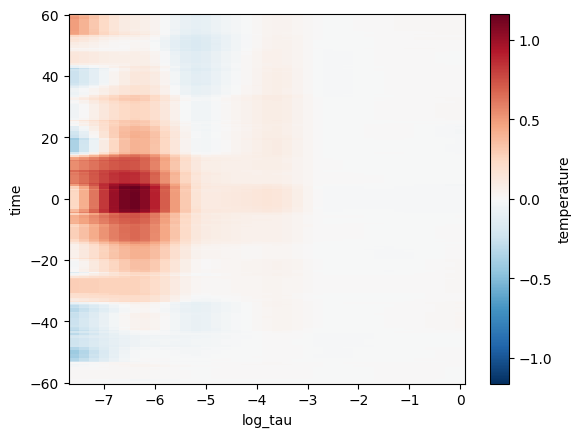

In [214]:
(good_iris2p_moss.temperature - good_iris2p_moss.temperature.sel(time=-60)).mean(dim='moss_no', skipna=True).plot()

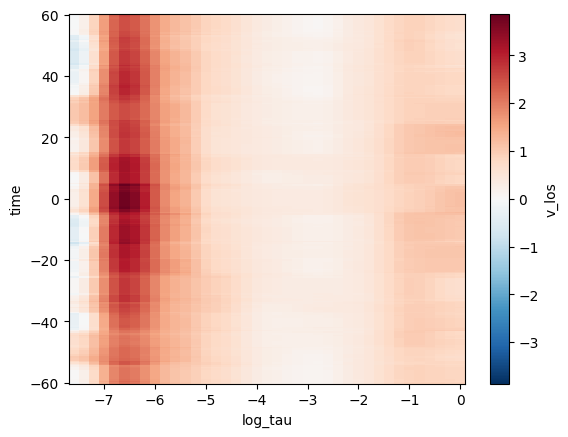

In [215]:
good_iris2p_moss.v_los.mean(dim='moss_no', skipna=True).plot()

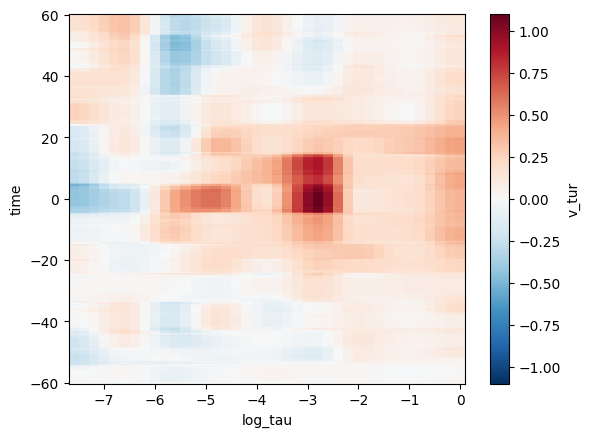

In [216]:
(good_iris2p_moss.v_tur - good_iris2p_moss.v_tur.sel(time=-60)).mean(dim='moss_no', skipna=True).plot()

In [217]:
good_iris2p_moss['n_e'] = xr.where(good_iris2p_moss['n_e'] < 0, np.nan, good_iris2p_moss['n_e'])

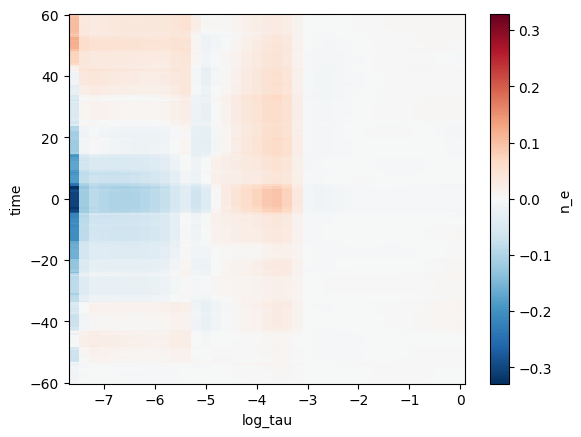

In [218]:
(good_iris2p_moss.n_e - good_iris2p_moss.n_e.isel(time=0)).mean(dim='moss_no', skipna=True).plot()

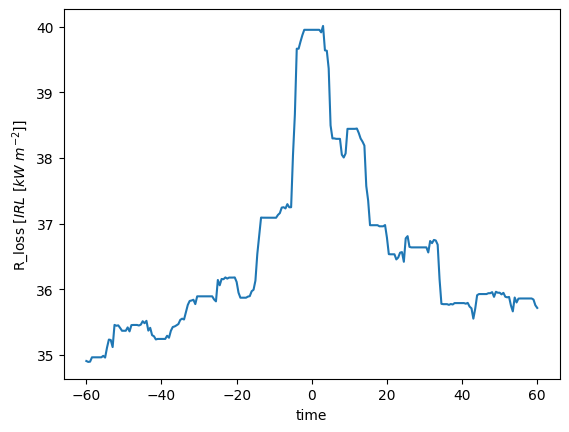

In [219]:
good_iris2p_moss.R_loss.mean(dim='moss_no', skipna=True).plot()

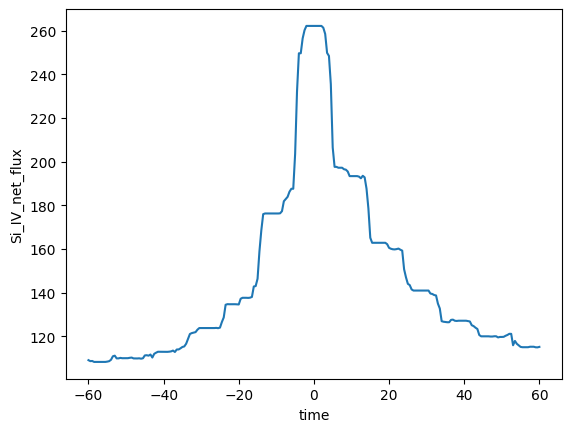

In [220]:
good_iris2p_moss.Si_IV_net_flux.mean(dim='moss_no', skipna=True).plot()

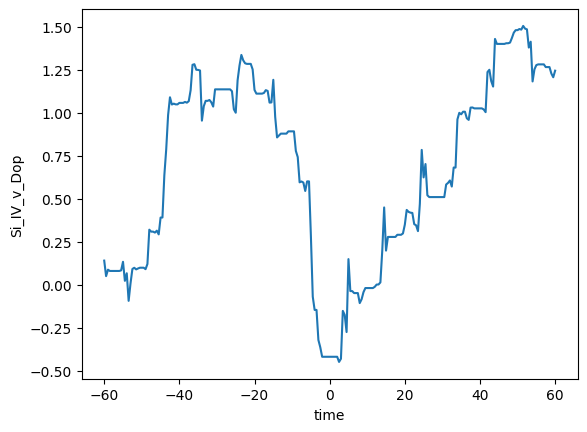

In [221]:
good_iris2p_moss.Si_IV_v_Dop.mean(dim='moss_no', skipna=True).plot()

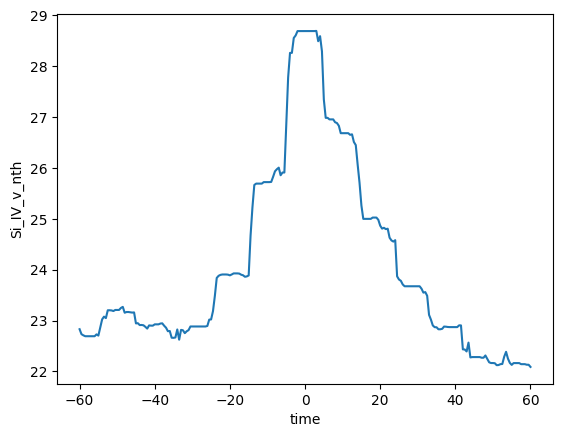

In [178]:
good_iris2p_moss.Si_IV_v_nth.mean(dim='moss_no', skipna=True).plot()

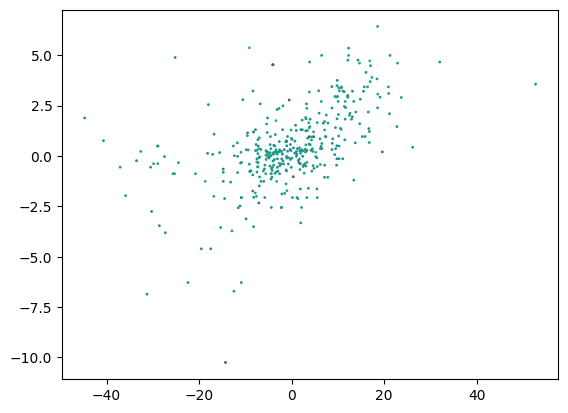

In [179]:
mg_ii_log_tau = (good_iris2p_moss.log_tau > -5)*(good_iris2p_moss.log_tau < -3)
mg_ii_dop = good_iris2p_moss.v_los.sel(time=0).isel(log_tau=mg_ii_log_tau).mean(dim=['log_tau'])
mg_ii_t = good_iris2p_moss.temperature.sel(time=0).isel(log_tau=mg_ii_log_tau).mean(dim=['log_tau'])
plt.scatter(good_iris2p_moss.Si_IV_v_Dop.sel(time=0), 
            mg_ii_dop, s=1, c=mg_ii_t, vmin=2, vmax=10) 

In [78]:
try:
    os.mkdir(file_path+f"profiles/")
except:
    pass
gap = 0.05
top = 0.02
ys = (1-gap*7-top)/6
ax_pos = [[gap, 1-(gap+ys)-top,   1-gap*2, ys],
        [gap, 1-(gap+ys)*2-top, 0.3, ys],
        [0.5-ys/2, 1-(gap+ys)*2-top, ys, ys],
        [1-gap-0.3, 1-(gap+ys)*2-top, 0.3, ys],
        [gap, 1-(gap+ys)*3-top, 1-gap*2, ys],
        [gap, 1-(gap+ys)*4-top, 1-gap*2, ys],
        [gap, 1-(gap+ys)*5-top, 0.38, ys],
        [1-gap-0.38, 1-(gap+ys)*5-top, 0.38, ys],
        [gap, 1-(gap+ys)*6-top, 0.38, ys],
        [1-gap-0.38, 1-(gap+ys)*6-top, 0.38, ys]]
wv_range = np.array([[1333.5, 1336.5], 
                    [2784.8, 2786.2], 
                    [2790.8, 2792.2], 
                    [2792.8, 2793.4], 
                    [2793.5, 2806.5], 
                    [2808.8, 2811.2],
                    [2814.8, 2815.6], 
                    [2827.21, 2827.44]])
line_center = np.array([1334.53, 1335.71, 2785.46, 2791.60, 2793.22, 
                         2796.35, 2798.85, 2803.53, 2809.15, 2810.58, 
                         2815.18, 2827.33])
line_width = np.array([0.25, 0.25, 0.1, 0.25, 0.1, 
                       0.7, 0.25, 0.7, 0.1, 0.1, 
                       0.1, 0.05])
line_name = ['C II', 'C II', 'Ti II', 'Mg II UV1', 'Fe I', 
             'Mg II k', 'Mg II UV3', 'Mg II h', 'Fe I', 'C I', 
             'Ni II', 'Fe I']

for num in iris2plus_moss.moss_no.data:
    fig1 = plt.figure(figsize=(8, 10))
    axs = []
    weight_info = np.array(profiles[num][3])[:, 2:4]
    time_arg = iris2plus_moss.sel(moss_no=num).time_arg.data
    peak_ind = np.where(np.unique(time_arg) == time_arg[nt//2])[0].item()
    for i, _ in enumerate(wv_range):
        ax_ = fig1.add_subplot(position=ax_pos[i])
        wv = np.array(profiles[num][0])
        ax_.set_xlim(wv_range[i])
        idx = (wv > wv_range[i][0])*(wv < wv_range[i][1])
        ax_.plot(wv[idx], profiles[num][1][peak_ind, idx], 'k')
        ax_.plot(wv[idx], profiles[num][2][peak_ind, idx], 'r', alpha=0.8)
        ylim = ax_.get_ylim()
        for j, lc in enumerate(line_center):
            if np.prod(wv_range[i] - lc) < 0:
                k = np.where(abs(lc - weight_info[:, 0]) < line_width[j])[0]
                weight = 0 if len(k) == 0 else weight_info[k, 1].item()
                ax_.plot([lc]*2, ylim, ':', color='gray')
                t01 = ax_.text(lc, np.diff(ylim)*0.05+ax_.get_ylim()[1], 
                             f'{line_name[j]} {line_center[j]}', 
                             color='gray', ha='center', weight='3', size=9)
                t02 = ax_.annotate(f' x {weight:.1f}', xycoords=t01, xy=(1,0), 
                             color='orange', weight='1', size=7, va='bottom')
                
                if weight != 0:
                    ax_.axvspan(lc-line_width[j], lc+line_width[j], color='k', 
                                alpha=0.2, ls='')
                    gray_idx = (wv > lc-line_width[j])*(wv < lc+line_width[j])
        ax_.ticklabel_format(useOffset=False)
        axs.append(ax_)
    for ii in range(3):
        ax_ = fig1.add_subplot(position=[gap*2+ii*(0.52-0.5*ys-2*gap), 1-(gap+ys)*3+ys*0.4-top, ys*0.9, ys*0.5])
        ax_.set_xlim(-0.3, 0.3)
        ax_.xaxis.set_ticks([-0.3, 0, 0.3])
        nwv = wv - line_center[5+ii]
        idx = abs(nwv) < 0.3
        ax_.plot(nwv[idx], profiles[num][1][peak_ind, idx], 'k')
        ax_.plot(nwv[idx], profiles[num][2][peak_ind, idx], 'r')
        axs.append(ax_)
    
    model_col = ['orange', 'blue', 'green', 'purple']
    model_name = ['temperature', 'n_e', 'v_tur', 'v_los', 'R_loss']
    for i, ii in enumerate([8, 9]):
        ax_ = fig1.add_subplot(position=ax_pos[ii])
        ax_.set_xlim(-7, 0)
        ax_.set_ylim([[3, 30], [0, 20]][i])
        ax_.plot(iris2plus_moss.log_tau, iris2plus_moss[model_name[i*2]].sel(moss_no=num, time=0), 
                     color=model_col[i*2])
        ax_.set(ylabel=iris2plus_moss[model_name[i*2]].attrs['units'], xlabel=r'$log(\tau$)')
        ax_.spines['left'].set(color=model_col[i*2])
        ax_.yaxis.label.set_color(model_col[i*2])
        ax_.tick_params(axis='y', colors=model_col[i*2])
    
        
        twin1_ = ax_.twinx()
        twin1_.set_position(ax_pos[ii])
        twin1_.spines['left'].set_visible(False)
        twin1_.set_ylim([[10, 14], [-30, 30]][i])
        twin1_.plot(iris2plus_moss.log_tau, iris2plus_moss[model_name[i*2+1]].sel(moss_no=num, time=0), 
                     color=model_col[i*2+1])
        twin1_.set(ylabel=iris2plus_moss[model_name[i*2+1]].attrs['units'])
        twin1_.spines['right'].set(color=model_col[i*2+1])
        twin1_.yaxis.label.set_color(model_col[i*2+1])
        twin1_.tick_params(axis='y', colors=model_col[i*2+1])
        axs.append(ax_)
    ax_.text(0.01, 0.98, f"No.{num:4.0f}"+'  '+os.path.basename(iris2plus_moss['IRIS2+files'].sel(moss_no=num).item()), 
             transform=fig1.transFigure, fontfamily='monospace', fontsize=15)
    ax_.text(0.01, 0.95, f"$\\chi^2$ = {profiles[num][4][peak_ind]:7.2f}", 
             transform=fig1.transFigure, fontfamily='monospace', fontsize=15)
    fig1.savefig(file_path+f"profiles/{num:04d}.png", bbox_inches='tight')
    plt.close(fig1)
with open(file_path+'chi_square', 'wb') as fp:
    pickle.dump(chi_square, fp) 

In [191]:
np.where(['Si IV' in line for line in lines])[0][-1]

np.int64(1)

In [184]:
lines

array(['C II 1336', 'Si IV 1394', 'Mg II k 2796'], dtype='<U12')

In [160]:
iris2plus_moss.IRISlv2_files.sel(moss_no=0)

<xarray.DataArray 'IRISlv2_files' ()> Size: 8B
array('/irisa/data/level2/2015/09/16/20150916_044717_3680086902/iris_l2_20150916_044717_3680086902_raster_t000_r00000.fits',
      dtype=object)
Coordinates:
    moss_no  int64 8B 0

In [92]:
import pdb

In [103]:
sat_chi2 = []
for i, profile in enumerate(profiles):
    okay = (profile[4] > 0) * (profile[4] < 0.5)
    if np.sum(okay) == len(profile[4]):
        sat_chi2.append(i)
print(len(sat_chi2))
sel_iris2plus_moss = iris2plus_moss.sel(moss_no = sat_chi2)

344


In [152]:
iris2plus_moss.time_arg.isel(moss_no=0)

<xarray.DataArray 'time_arg' (time: 241)> Size: 2kB
array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  9.,  9., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 13., 13., 13.,
       13., 13., 13., 13., 13., 13., 13., 13., 13., 14., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 14., 14., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 16., 16.])
Coordinates:
  * time     (time) float64 2kB -60.0 -59.5 -59.0 -58.5 ... 58.5 59.0 59.5 60.0
    moss_no  int64 8B 0

In [134]:
iris2plus_moss.transpose('log_tau', 'time', ...)

<xarray.Dataset> Size: 506MB
Dimensions:        (time: 241, log_tau: 39, moss_no: 1662, line_center: 12,
                    line_width: 12)
Coordinates:
  * line_center    (line_center) float64 96B 1.335e+03 1.336e+03 ... 2.827e+03
  * line_width     (line_width) float64 96B 0.25 0.25 0.1 0.25 ... 0.1 0.1 0.05
  * time           (time) float64 2kB -60.0 -59.5 -59.0 -58.5 ... 59.0 59.5 60.0
  * log_tau        (log_tau) float64 312B -7.6 -7.4 -7.2 -7.0 ... -0.4 -0.2 0.0
  * moss_no        (moss_no) int64 13kB 0 1 2 3 4 5 ... 1657 1658 1659 1660 1661
Data variables:
    temperature    (log_tau, time, moss_no) float64 125MB 4.842 4.893 ... 5.885
    v_los          (log_tau, time, moss_no) float64 125MB 37.63 ... 0.1624
    v_tur          (log_tau, time, moss_no) float64 125MB 15.0 ... 0.009135
    n_e            (log_tau, time, moss_no) float64 125MB 9.661 8.736 ... 13.48
    R_loss         (time, moss_no) float64 3MB 87.94 90.51 93.21 ... 4.479 4.479
    time_arg       (time, moss_no) float64 3MB 0.0 18.0 17.0 ... 804.0 804.0
    time_cadence   (moss_no) float64 13kB 6.0 6.0 6.0 6.0 ... 9.0 9.0 9.0 9.0
    IRIS2+files    (moss_no) object 13kB '/Users/khcho/Desktop/IRIS-moss-main...
    IRISlv2_files  (moss_no) object 13kB '/irisa/data/level2/2015/09/16/20150...
    percentage     (moss_no) float64 13kB 11.55 11.55 11.55 ... 0.04429 0.04429

In [136]:
temp_diff = (sel_iris2plus_moss.temperature - sel_iris2plus_moss.temperature.isel(time=0)).mean('moss_no').transpose()
v_los = sel_iris2plus_moss.v_los.mean('moss_no').transpose()
v_tur = sel_iris2plus_moss.v_tur.mean('moss_no').transpose()
n_e_ratio = (sel_iris2plus_moss.n_e - sel_iris2plus_moss.n_e.isel(time=0)).mean('moss_no').transpose()
R_loss = sel_iris2plus_moss.R_loss.mean('moss_no')

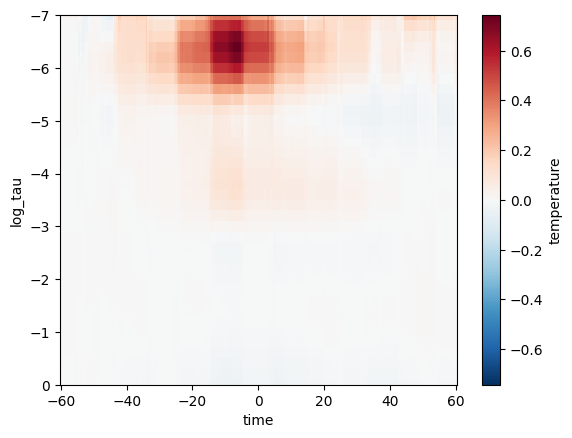

In [143]:
temp_diff.plot(ylim=[0, -7])

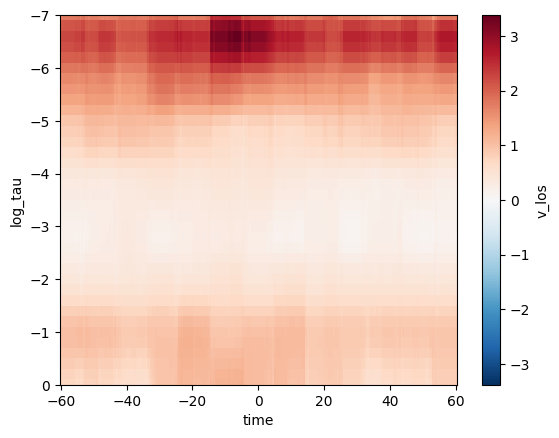

In [144]:
v_los.plot(ylim=[0, -7])

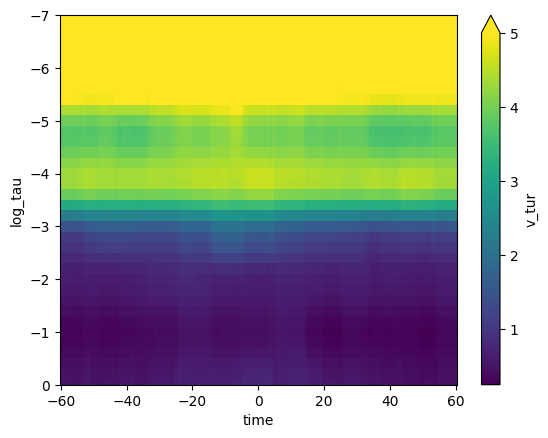

In [145]:
v_tur.plot(vmax=5, ylim=[0, -7])

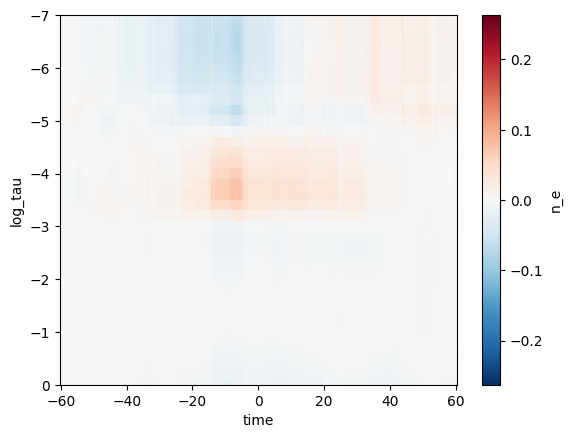

In [146]:
n_e_ratio.plot(ylim=[0, -7])

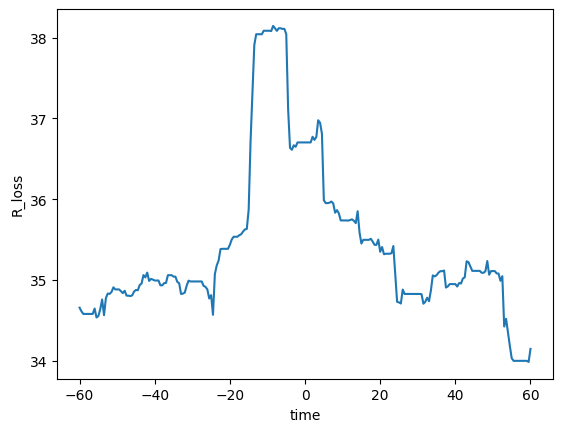

In [147]:
R_loss.plot()

In [121]:
pars

array([   0,    1,    2, ..., 3056, 3057, 3058], dtype='>i4')

In [68]:
print(profiles[10][4] < 0.5)
print(profiles[10][4] > 0)
print((profiles[10][4] < 0.5) * (profiles[10][4] > 0))

[False False False  True False False  True False False False False False
 False False False  True  True False False  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[False False False  True False False  True False False False False False
 False False False  True  True False False  True  True]


In [485]:
import matplotlib.colors as mcolors

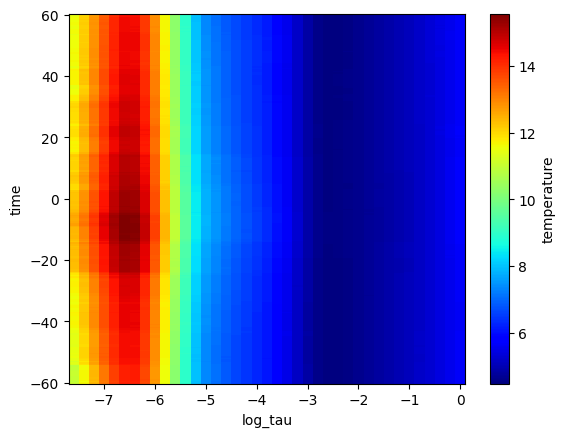

In [524]:
iris2plus_moss.temperature.mean(dim='moss_no').plot(cmap="jet", norm=mcolors.PowerNorm(1))

(2795.0, 2797.0)

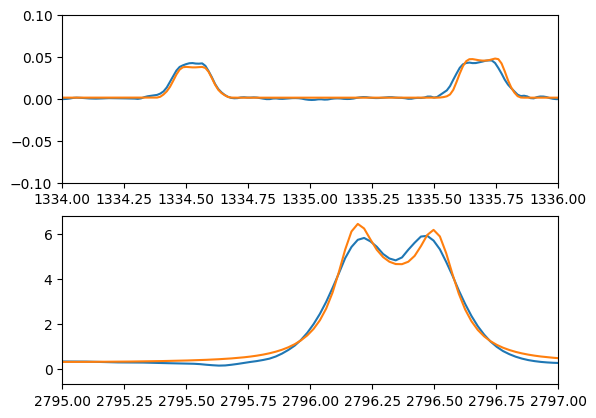

In [533]:
fig, ax = plt.subplots(2)
ax[0].plot(profiles[0][0], profiles[0][1])
ax[0].plot(profiles[0][0], profiles[0][2])
ax[0].set_xlim(1334, 1336)
ax[0].set_ylim(-0.1, 0.1)
ax[1].plot(profiles[0][0], profiles[0][1])
ax[1].plot(profiles[0][0], profiles[0][2])
ax[1].set_xlim(2795, 2797)




In [452]:
data0['wl2size']

[np.int64(232), np.int64(28), np.int64(472), np.int64(32)]

In [406]:
iris2plus_moss

<xarray.Dataset> Size: 506MB
Dimensions:        (time: 241, log_tau: 39, moss_no: 1662, arbitrary: 2)
Coordinates:
  * time           (time) float64 2kB -60.0 -59.5 -59.0 -58.5 ... 59.0 59.5 60.0
  * log_tau        (log_tau) float64 312B -7.6 -7.4 -7.2 -7.0 ... -0.4 -0.2 0.0
  * arbitrary      (arbitrary) int64 16B 0 1
  * moss_no        (moss_no) int64 13kB 0 1 2 3 4 5 ... 1657 1658 1659 1660 1661
Data variables:
    temperature    (time, log_tau, moss_no) float64 125MB 4.842 4.893 ... 0.0
    v_los          (time, log_tau, moss_no) float64 125MB 37.63 -4.193 ... 0.0
    v_tur          (time, log_tau, moss_no) float64 125MB 15.0 14.92 ... 0.0 0.0
    n_e            (time, log_tau, moss_no) float64 125MB 4.581e+09 ... 0.0
    R_loss         (time, arbitrary, moss_no) float64 6MB 87.94 90.51 ... 0.0
    time_cadence   (moss_no) float64 13kB 6.0 6.0 6.0 6.0 ... 0.0 0.0 0.0 0.0
    IRIS2+files    (moss_no) object 13kB '/Users/khcho/Desktop/IRIS-moss-main...
    IRISlv2_files  (moss_no) object 13kB '/irisa/data/level2/2015/09/16/20150...
    percentage     (moss_no) float64 13kB 16.86 16.86 16.86 ... 0.0 0.0 0.0

In [417]:
data0.keys()

dict_keys(['data', 'inv', 'model', 'wl', 'wlc', 'wl2size', 'wl2scl', 'extent', 'extent_coords', 'mu', 'texp', 'obsid', 'percentages', 'jbl_file_saving_stamptime'])

In [427]:
data0['model'][0]

{'poi': [],
 'data': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0.

In [295]:
iris2plus_moss

<xarray.Dataset> Size: 625MB
Dimensions:        (time: 241, log_tau: 39, moss_no: 1662)
Coordinates:
  * time           (time) float64 2kB -60.0 -59.5 -59.0 -58.5 ... 59.0 59.5 60.0
  * log_tau        (log_tau) float64 312B -7.6 -7.4 -7.2 -7.0 ... -0.4 -0.2 0.0
  * moss_no        (moss_no) int64 13kB 0 1 2 3 4 5 ... 1657 1658 1659 1660 1661
Data variables:
    temperature    (time, log_tau, moss_no) float64 125MB 4.842 4.893 ... 0.0
    v_los          (time, log_tau, moss_no) float64 125MB 4.842 4.893 ... 0.0
    v_tur          (time, log_tau, moss_no) float64 125MB 4.842 4.893 ... 0.0
    n_e            (time, log_tau, moss_no) float64 125MB 4.842 4.893 ... 0.0
    R_loss         (time, log_tau, moss_no) float64 125MB 4.842 4.893 ... 0.0
    time_cadence   (moss_no) float64 13kB 6.0 6.0 6.0 6.0 ... 0.0 0.0 0.0 0.0
    IRIS2+files    (moss_no) <U1 7kB '/' '/' '/' '/' '/' '/' ... '' '' '' '' ''
    IRISlv2_files  (moss_no) <U1 7kB '/' '/' '/' '/' '/' '/' ... '' '' '' '' ''
    percentage     (moss_no) float64 13kB 16.86 16.86 16.86 ... 0.0 0.0 0.0